Title:   ***Anomaly-Based Intrusion Detection Using Autoencoders***

This is just a **draft** and yet a very restrictive first draft from my project on  attack detection using autoencoders taking into consideration uncertainty.

In this notebook, I train the model on the CIC-IDS2017 dataset from the Canadian Institute for Cybersecurity.

Author: **Gilda Rech**


### Implementation WorkFlow

1) **Modules import**

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [ ]:
print(os.getcwd())

/content


2) **Data Import**

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#**CIC-IDS2017 Database**

In [ ]:
data_cic_ids2017_day5=pd.read_csv("/content/drive/MyDrive/.../Datasets/CIC-IDS2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
#data_cic_ids2017_day5=pd.read_csv("../Datasets/CIC-IDS2017/MachineLearningCVE/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")

Column names of the **data_cic_ids2017_day5** contain spaces and I could not call columns with their names, so here I remove the spaces.

In [ ]:
data_cic_ids2017_day5.columns=data_cic_ids2017_day5.columns.str.replace(" ", "")

In [ ]:
data_cic_ids2017_day5.head(10)

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,54871,1022,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,54925,4,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,54925,42,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,9282,4,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,55153,4,2,0,37,0,31,6,18.5,17.67767,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Total number of Columns in the dataset and examples in the dataset

In [ ]:
data_cic_ids2017_day5.shape

(225745, 79)

Viewing the types of data

In [ ]:
data_cic_ids2017_day5.dtypes

DestinationPort              int64
FlowDuration                 int64
TotalFwdPackets              int64
TotalBackwardPackets         int64
TotalLengthofFwdPackets      int64
                            ...   
IdleMean                   float64
IdleStd                    float64
IdleMax                      int64
IdleMin                      int64
Label                       object
Length: 79, dtype: object

Total number of **examples**: 225745 <br>
Total number of **features**: 78 <br>
Column **Label**: 1

Knowing Numerical columns in the dataset

In [ ]:
numerical_columns = data_cic_ids2017_day5._get_numeric_data().columns
len(numerical_columns)

78

**Remark:** since the dataset is composed of **79** columns composed of **78** columns of numerical values, with the last categorical column represents the Labels.<br>
In **Conclusion**, the set of features is already numerical so we need just to tranform the **Label** column into numerical

Checking if there are missing values in my dataframe and knowing their positions

In [ ]:
np.where(pd.isnull(data_cic_ids2017_day5))

(array([  6796,  14739,  15047, 209728]), array([14, 14, 14, 14]))

In [ ]:
data_cic_ids2017_day5['FlowBytes/s'][6796]

nan

Checking if there are infinity values in the dataframe and counting their number

In [ ]:
n=len(data_cic_ids2017_day5.columns)
number=0
for i in range(n-1): number += np.isinf(data_cic_ids2017_day5[data_cic_ids2017_day5.columns[i]]).values.sum() 
print(number)

64


Replacing all infs values with nan

In [ ]:
data_cic_ids2017_day5= data_cic_ids2017_day5.replace(np.inf, np.nan) 

In [ ]:
new_data_cic_ids2017_day5=data_cic_ids2017_day5.fillna(data_cic_ids2017_day5.mean(), inplace=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


Checking there for **nan** values in the new dataset (expecting 0)

In [ ]:
np.where(pd.isnull(new_data_cic_ids2017_day5))

(array([], dtype=int64), array([], dtype=int64))

Viewing the new dataset

In [ ]:
new_data_cic_ids2017_day5

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225741,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225742,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
225743,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Selecting columns that are object type

In [ ]:
list(new_data_cic_ids2017_day5.select_dtypes(include=['object']).columns)

['Label']

In [ ]:
new_data_cic_ids2017_day5["Label"].value_counts()

DDoS      128027
BENIGN     97718
Name: Label, dtype: int64

Displaying the different categories in the Label coulmn and their number

In [ ]:
data_cic_ids2017_day5["Label"].value_counts()

DDoS      128027
BENIGN     97718
Name: Label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


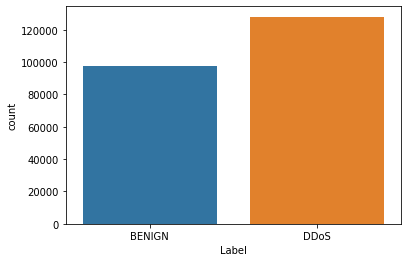

In [ ]:
sns.countplot(data_cic_ids2017_day5["Label"])


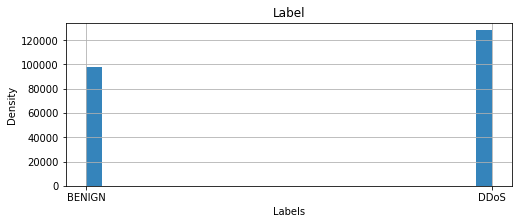

In [ ]:
if "Label" in data_cic_ids2017_day5.columns:
    data_cic_ids2017_day5["Label"].hist(figsize=(8,3), alpha=0.9, bins=25);
    plt.title("Label")
    plt.xlabel("Labels")
    plt.ylabel("Density")
    plt.savefig("Label.png", dpi=300)

Percentage of data by label

In [ ]:
print(f"pourcentage of DDOS {(128027/data_cic_ids2017_day5.shape[0])*100} \n")
print(f"pourcentage of BENIGN {(97718/data_cic_ids2017_day5.shape[0])*100} \n")

pourcentage of DDOS 56.713105495138315 

pourcentage of BENIGN 43.28689450486168 



Replacing the Category BEGNIN by 0 and DDOS by 1

In [ ]:
new_data_cic_ids2017_day5['Label'] = new_data_cic_ids2017_day5['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

Checking the dataset Label column

In [ ]:
new_data_cic_ids2017_day5

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61374,61,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
225741,61378,72,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
225742,61375,75,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
225743,61323,48,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


Review the types of Data in each column (Particularly the **Label** column)

In [ ]:
new_data_cic_ids2017_day5.dtypes

DestinationPort              int64
FlowDuration                 int64
TotalFwdPackets              int64
TotalBackwardPackets         int64
TotalLengthofFwdPackets      int64
                            ...   
IdleMean                   float64
IdleStd                    float64
IdleMax                      int64
IdleMin                      int64
Label                        int64
Length: 79, dtype: object

Checking for min values and max values to see if data is high balanced

In [ ]:
new_data_cic_ids2017_day5.min(), new_data_cic_ids2017_day5.max()

(DestinationPort            0.0
 FlowDuration              -1.0
 TotalFwdPackets            1.0
 TotalBackwardPackets       0.0
 TotalLengthofFwdPackets    0.0
                           ... 
 IdleMean                   0.0
 IdleStd                    0.0
 IdleMax                    0.0
 IdleMin                    0.0
 Label                      0.0
 Length: 79, dtype: float64, DestinationPort                65532.0
 FlowDuration               119999937.0
 TotalFwdPackets                 1932.0
 TotalBackwardPackets            2942.0
 TotalLengthofFwdPackets       183012.0
                               ...     
 IdleMean                   120000000.0
 IdleStd                     65300000.0
 IdleMax                    120000000.0
 IdleMin                    120000000.0
 Label                              1.0
 Length: 79, dtype: float64)

**Application of PCA** to the data: Since our data variables are continuous and numerical now, we then can apply PCA <br>
We can remove the Label column since we are just interested by features. <br>
1- We isolate features <br>
2- We normalize data since it is unbalanced (difference between max values and mins is big) <br>
3- We apply PCA on normalized and non-normalized data

In [ ]:
features_only=new_data_cic_ids2017_day5.drop('Label', axis=1, inplace=False)
labels_only=new_data_cic_ids2017_day5.iloc[:, -1]
features_list=features_only.columns.tolist()
features_only

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,61374,61,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
225741,61378,72,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
225742,61375,75,1,1,6,6,6,6,6.0,0.0,...,0,20,0.0,0.0,0,0,0.0,0.0,0,0
225743,61323,48,2,0,12,0,6,6,6.0,0.0,...,1,20,0.0,0.0,0,0,0.0,0.0,0,0


In [ ]:
features_only_min_max=(features_only-features_only.min(axis=0))/(features_only.max(axis=0)-features_only.min(axis=0))

In [ ]:
features_only_min_max=features_only_min_max.fillna(0)

z-score normalization

In [ ]:
features_only_standardized = StandardScaler().fit_transform(features_only)
features_only_standardized = pd.DataFrame(data = features_only_standardized, columns = features_list)
features_only_standardized

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
0,2.327831,-0.515210,-0.186406,-0.210191,-0.285426,-0.151982,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.188386,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
1,2.337398,-0.515207,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.269886,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
2,2.337449,-0.515209,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.269886,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
3,1.891022,-0.515209,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.269886,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
4,2.327730,-0.515210,-0.186406,-0.210191,-0.285426,-0.151982,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.188386,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,2.657324,-0.515208,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.269886,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
225741,2.657526,-0.515208,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.269886,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
225742,2.657375,-0.515208,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.269886,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071
225743,2.654742,-0.515209,-0.186406,-0.210191,-0.285426,-0.151982,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.188386,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071


Plotting the PCA Results on normalized data that describes each principal component with their variations

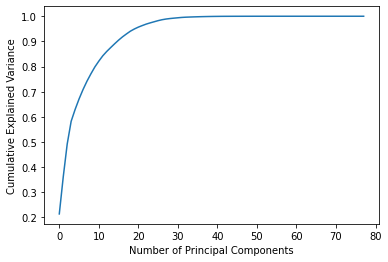

In [ ]:
pca_on_features_only_standardized = PCA().fit(features_only_standardized)
plt.plot(np.cumsum(pca_on_features_only_standardized.explained_variance_ratio_))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

minimum number of principal components required to preserve the 99% of the variance of data

In [ ]:
cumsum = np.cumsum(pca_on_features_only_standardized.explained_variance_ratio_)
number_of_principal_components_cic_ids2017 = np.argmax(cumsum >= 0.9)
number_of_principal_components_cic_ids2017

15

Otherway to get the number of principal components

In [ ]:
np.searchsorted(cumsum,0.9)

15

In [ ]:
pca_on_features_only_standardized.components_.shape

(78, 78)

From the above plot we see that about **29** PCA components are suffiscient to describe 100% of the variation or information in our data. We observe a reduction of dimensionality from **78** to **29**

Giving new feature names

In [ ]:
names = ["PC_{}".format(i+1) for i in range(29)]
new_pca_on_features_only = pd.DataFrame(data = principal_components, columns = names)
new_pca_on_features_only

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_20,PC_21,PC_22,PC_23,PC_24,PC_25,PC_26,PC_27,PC_28,PC_29
0,-3.631771e+07,-177554.649312,-158300.224309,3.274193e+06,-644551.888687,-65452.783063,-2.487945e+06,-531303.891502,-1.182607e+06,104856.619680,...,889943.461166,-2626.790614,-289.975095,-1101.389872,-2.835415,-2254.696209,337.781332,-35917.958118,199.916683,-29599.654181
1,-3.630052e+07,-175922.849176,-146280.745454,-6.181773e+05,-660438.668908,-66393.040524,-2.500174e+06,-534450.343091,-1.186883e+06,105029.341485,...,-21174.919188,2281.365844,614.409068,6097.421277,982.261611,-11236.023187,2112.357013,7834.876457,309.437569,-47189.412173
2,-3.630110e+07,-175968.483394,-146640.809088,-4.974438e+05,-659955.456848,-66373.281145,-2.499774e+06,-534367.020867,-1.186777e+06,104984.875540,...,233.739983,2168.229514,594.438199,5937.297233,962.791498,-11090.817692,2094.043454,19391.487484,311.673371,-46622.874275
3,-3.630165e+07,-176020.725892,-147015.847674,-3.752154e+05,-659454.461850,-66342.748680,-2.499369e+06,-534279.359083,-1.186637e+06,104963.151521,...,21732.179854,2042.525907,602.540779,5680.158756,971.471610,-10788.037692,2095.491443,30985.483319,241.695935,-37321.489409
4,-3.631771e+07,-177554.649909,-158300.224555,3.274193e+06,-644551.887761,-65452.782257,-2.487945e+06,-531303.893983,-1.182607e+06,104856.618164,...,889943.422056,-2626.791687,-289.970194,-1101.406790,-2.829661,-2254.666106,337.783139,-35917.976272,199.899284,-29597.723986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,-3.630094e+07,-175953.229891,-146536.736692,-5.315073e+05,-660096.278772,-66382.643948,-2.499889e+06,-534385.003352,-1.186807e+06,104995.057778,...,-5680.888315,2207.774958,580.154219,6049.456809,948.140154,-11241.889728,2085.419100,16205.623183,363.096985,-53023.777730
225741,-3.630080e+07,-175941.569484,-146446.307643,-5.615759e+05,-660217.214072,-66388.128464,-2.499988e+06,-534406.934939,-1.186837e+06,105004.024389,...,-11012.640775,2235.952675,585.120835,6089.346769,952.976809,-11278.159424,2090.000630,13327.506363,362.574171,-53169.083048
225742,-3.630077e+07,-175939.035579,-146426.381617,-5.682456e+05,-660243.934448,-66389.245031,-2.500010e+06,-534411.597019,-1.186843e+06,105006.381621,...,-12195.393391,2242.198811,586.233878,6098.159179,954.061939,-11286.130677,2091.020550,12689.041159,362.426482,-53197.466641
225743,-3.630114e+07,-175975.925393,-146709.384171,-4.781626e+05,-659877.712998,-66329.306016,-2.499737e+06,-534412.395606,-1.186807e+06,105012.577216,...,17580.627286,2072.568901,562.371726,5829.721795,920.368166,-10891.491000,2010.919489,-4738.475461,356.716612,-52559.305534


**Comment**:  Here the Value of the 
Finally ready to use dataframe with Labels column

In [ ]:
new_pca_on_features = pd.concat([new_pca_on_features_only, labels_only], axis = 1)
new_pca_on_features["Label"]

0         0
1         0
2         0
3         0
4         0
         ..
225740    0
225741    0
225742    0
225743    0
225744    0
Name: Label, Length: 225745, dtype: int64

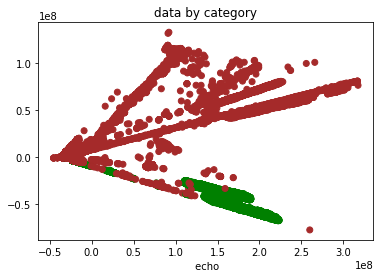

In [ ]:
color_list = [{0:"brown",1:"g"}[x] for x in new_pca_on_features['Label']]

#fig, ax = plt.subplots(2, 3)
fig, ax = plt.subplots()
ax.scatter(x=new_pca_on_features['PC_1'], y=new_pca_on_features["PC_2"], color=color_list)
ax.set_title("data by category")
ax.get_legend()
ax.set_xlabel(" echo")
plt.show()

Separating The data by Label Category

In [ ]:
# normalized dataset with z-score
new_data_cic_ids2017_day5=pd.concat([features_only_standardized, labels_only], axis=1)
new_data_cic_ids2017_day5_BENIGN=new_data_cic_ids2017_day5[new_data_cic_ids2017_day5["Label"]==0]
new_data_cic_ids2017_day5_DDOS=new_data_cic_ids2017_day5[new_data_cic_ids2017_day5["Label"]==1]
# here I verify if both the number of examples both for Benign and Ddos sum up to the one of the whole dataset
assert new_data_cic_ids2017_day5_BENIGN.shape[0]+new_data_cic_ids2017_day5_DDOS.shape[0]==new_data_cic_ids2017_day5.shape[0], "Something went wrong please re-check"
new_data_cic_ids2017_day5

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,2.327831,-0.515210,-0.186406,-0.210191,-0.285426,-0.151982,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071,0
1,2.337398,-0.515207,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071,0
2,2.337449,-0.515209,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071,0
3,1.891022,-0.515209,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071,0
4,2.327730,-0.515210,-0.186406,-0.210191,-0.285426,-0.151982,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,2.657324,-0.515208,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071,0
225741,2.657526,-0.515208,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071,0
225742,2.657375,-0.515208,-0.251245,-0.164225,-0.287273,-0.151829,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071,0
225743,2.654742,-0.515209,-0.186406,-0.210191,-0.285426,-0.151982,-0.285676,-0.133981,-0.314576,-0.269507,...,-0.35585,-0.231634,-0.061512,-0.231146,-0.226482,-0.472345,-0.283137,-0.478364,-0.391071,0


In [ ]:
#New data with features_only_min_max (to be removed if does not work)
new_data_cic_ids2017_day5=pd.concat([features_only_min_max, labels_only], axis=1)
new_data_cic_ids2017_day5_BENIGN=new_data_cic_ids2017_day5[new_data_cic_ids2017_day5["Label"]==0]
new_data_cic_ids2017_day5_DDOS=new_data_cic_ids2017_day5[new_data_cic_ids2017_day5["Label"]==1]
# here I verify if both the number of examples both for Benign and Ddos sum up to the one of the whole dataset
assert new_data_cic_ids2017_day5_BENIGN.shape[0]+new_data_cic_ids2017_day5_DDOS.shape[0]==new_data_cic_ids2017_day5.shape[0], "Something went wrong please re-check"
new_data_cic_ids2017_day5

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,0.837225,3.333335e-08,0.000518,0.00000,0.000066,0.000000,0.000514,0.004076,0.001552,0.0,...,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.840109,9.166671e-07,0.000000,0.00034,0.000033,0.000001,0.000514,0.004076,0.001552,0.0,...,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.840124,4.416669e-07,0.000000,0.00034,0.000033,0.000001,0.000514,0.004076,0.001552,0.0,...,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.705548,2.916668e-07,0.000000,0.00034,0.000033,0.000001,0.000514,0.004076,0.001552,0.0,...,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.837194,3.333335e-08,0.000518,0.00000,0.000066,0.000000,0.000514,0.004076,0.001552,0.0,...,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225740,0.936550,5.166669e-07,0.000000,0.00034,0.000033,0.000001,0.000514,0.004076,0.001552,0.0,...,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
225741,0.936611,6.083336e-07,0.000000,0.00034,0.000033,0.000001,0.000514,0.004076,0.001552,0.0,...,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
225742,0.936565,6.333337e-07,0.000000,0.00034,0.000033,0.000001,0.000514,0.004076,0.001552,0.0,...,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
225743,0.935772,4.083335e-07,0.000518,0.00000,0.000066,0.000000,0.000514,0.004076,0.001552,0.0,...,0.384615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


**Split data ready for train & test (cic_ids_2017_day_5_BENIGN):**

In [ ]:
X_BENIGN, Y_BENIGN =new_data_cic_ids2017_day5_BENIGN.drop('Label', axis=1, inplace=False), new_data_cic_ids2017_day5_BENIGN.iloc[:, -1]
X_train_BENIGN, X_test_BENIGN, y_train_BENIGN, y_test_BENIGN = train_test_split(X_BENIGN, Y_BENIGN, test_size=0.30, random_state=1)
X_train_BENIGN

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
32535,0.779039,0.000919,0.001554,0.001020,0.063389,0.000005,0.750000,0.000000,0.750000,0.616844,...,0.001554,0.384615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
224038,0.000809,0.008533,0.000000,0.000340,0.000257,0.000012,0.004024,0.031929,0.012154,0.000000,...,0.000000,0.384615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
218218,0.001221,0.002036,0.001036,0.001360,0.001661,0.000229,0.026027,0.000000,0.026205,0.026225,...,0.000518,0.615385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
120226,0.441784,0.180057,0.000000,0.002379,0.000033,0.000008,0.000514,0.004076,0.001552,0.000000,...,0.000000,0.384615,0.000473,0.000000,0.000473,0.000473,0.180000,0.000000,0.180000,0.180000
223511,0.006760,0.000794,0.000000,0.000340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.615385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32122,0.802249,0.594265,0.003107,0.003059,0.063455,0.000012,0.375000,0.000000,0.429015,0.317785,...,0.002589,0.384615,0.000595,0.000000,0.000595,0.000595,0.593333,0.000000,0.593333,0.593333
201376,0.000809,0.000257,0.000518,0.000680,0.000382,0.000026,0.002997,0.023777,0.009051,0.000000,...,0.000518,0.615385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
138517,0.486663,0.025066,0.000000,0.001700,0.000033,0.000006,0.000514,0.004076,0.001552,0.000000,...,0.000000,0.384615,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5192,0.006760,0.044111,0.002589,0.001360,0.003339,0.000032,0.044264,0.000000,0.026334,0.030527,...,0.002589,0.384615,0.001540,0.000000,0.001540,0.001540,0.042828,0.000000,0.042828,0.042828


**Split data ready for train & test (cic_ids_2017_day_5_DDOS):**

In [ ]:
X_DDOS, Y_DDOS =new_data_cic_ids2017_day5_DDOS.drop('Label', axis=1, inplace=False), new_data_cic_ids2017_day5_DDOS.iloc[:, -1]
X_train_DDOS, X_test_DDOS, y_train_DDOS, y_test_DDOS = train_test_split(X_DDOS, Y_DDOS, test_size=0.30, random_state=1)
X_train_DDOS.shape

(89618, 78)

#**Some functions**

In [ ]:
class tools:
  """ Class that contains implementation of functions to be used in the project
      - PCA : method that performs pca dimensionality reduction
      - split_data : method that splits data into training and test data
      - scale : method that scales or standardize input data
      - AR : method that computes the Anomaly Score
      - AQ : method that computes the quantile - based Anomaly score
      - AQN : method that computes the normalised Anomaly score. It is based on the Mahalanobis distance
  """
  def __init__(self):
    pass

  def PCA(self, df, k):
    """ function that performs PCA """
    x = np.array(df)
    # step 1: calculate the Mean normalization of x
    x = x-np.mean(x, axis=0)

    # step 2: calculate covariance matrix from the normalized_x
    # make the parameter rowvar = False; check the documentation of np.cov to see why..
    covariance_matrix=np.cov(x, rowvar=False)

    # step 3: compute the eigen values and eigen vectors
    eigen_values =np.linalg.eigh(covariance_matrix)[0]
    eigen_vectors = np.linalg.eigh(covariance_matrix)[1]

    # step 4: sort the eigen values in "descending" order, then use this sorted indicies to sort the eigen vectors.
    sort=np.argsort(eigen_values)[::-1]
    eigen_values_sort=eigen_values[sort]
    eigen_vectors_sort=eigen_vectors[:,sort]

    # step 5: select k eigen vectors
    select_eigen_vectors=eigen_vectors_sort[:,0:k]

    # step 6: transform the data, the reduced x
    z=np.dot(select_eigen_vectors.transpose(), x.transpose()).transpose()
    
    return z

  def split_data(self, df, train_percent= 0.8):
    """ method that splits data of a dataframe into x_train, x_test, y_train, y_test
    """
    np.random.seed(2)
    perm = np.random.permutation(df.index)
    n= len(df)
    train_index = int(train_percent * n)
    train = df.iloc[perm[:train_index]]
    test = df.iloc[perm[train_index:]]
    x_train, x_test, y_train, y_test= train.iloc[:, :-1], test.iloc[:, :-1], train.iloc[:, -1], test.iloc[:, -1]

    return x_train.values, x_test.values, y_train.values, y_test.values

    def scale(self, x):
      """ 
      method that scales or standardize data in dataframe
      """
      x_scaled= (x-x.mean(0))/x.std(0)
      return x_scaled
    
  def AR(self, Erec, Eunc, p=2):
    """ method that computes the Anomaly Score.
      Erec: is the reconstruction Error. Erec = x-x_m where m represents the median quantile
      Eunc: is the uncertainty Error. Eunc=x_u-x_l where u and l represent respectively the upper and lower quantiles
      Formula AR=(sqrt(Erec x Erec.transpose))^p/d_E, where d_E is the dimension of the corresponding vector E.
      p: is equal to 2 for MSE or 1 for MAE
    """
    return ((np.sqrt(Erec@Erec.T))**p)/Erec.shape[0]
  
  def AQ(self, Erec, Eunc, p=2):
    """ method that computes the quantile - based Anomaly score.
        Erec: is the reconstruction Error. Erec = x-x_m where m represents the median quantile
        Eunc: is the uncertainty Error. Eunc=x_u-x_l where u and l represent respectively the upper and lower quantiles
        E: the matrix given by E=[Erec, Eunc]
        Formula AQ=(sqrt(E x E.transpose))/d_E where d_E is the dimension of the corresponding vector E
        p: is equal to 2 for MSE or 1 for MAE
    """
    E=np.array([Erec, Eunc])
    return (np.sqrt(E@E.T)**p)/E.shape[0]

  def AQN(self, Erec, Eunc, p=2):
    """ method that computes the normalised Anomaly score. It is based on the Mahalanobis distance
        Erec: is the reconstruction Error. Erec = x-x_m where m represents the median quantile
        Eunc: is the uncertainty Error. Eunc=x_u-x_l where u and l represent respectively the upper and lower quantiles
        E: the matrix given by E=[Erec, Eunc]
        Formula AQN=(sqrt((E-u) x S^-1 x (E-u)).transpose))**p where  u and S are the channel-wise mean and covariance matrix obtained from E of the training set.
    """
    E=np.array([Erec, Eunc])
    u, S = np.mean(E), np.cov(E, rowvar=False)
    return (np.sqrt((E-u)@np.linalg.inv(S)@(E-u).T))**p


#**Construction of the Model** : 


**Variational Autoencoder (VA)** <br>
The Encoder outputs the mean sample and variance

In [ ]:
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

In [ ]:
cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

Preparing data for training and test <br>
We consider the train data and test data as X_train_DDOS

In [ ]:
X_train_DDOS_torch = torch.from_numpy(X_train_DDOS.values).float()
X_test_DDOS_torch = torch.from_numpy(X_train_DDOS.values).float()

train_loader = DataLoader(X_train_DDOS_torch, batch_size=100, shuffle=True, num_workers=0)
test_loader = DataLoader(X_train_DDOS_torch, batch_size=100, shuffle=True, num_workers=0)
X_train_DDOS_torch

tensor([[0.0012, 0.0557, 0.0021,  ..., 0.0000, 0.0557, 0.0557],
        [0.0012, 0.0006, 0.0010,  ..., 0.0000, 0.0000, 0.0000],
        [0.0012, 0.0508, 0.0016,  ..., 0.0000, 0.0508, 0.0508],
        ...,
        [0.0012, 0.0015, 0.0010,  ..., 0.0000, 0.0000, 0.0000],
        [0.0012, 0.0014, 0.0010,  ..., 0.0000, 0.0000, 0.0000],
        [0.0012, 0.0593, 0.0021,  ..., 0.0000, 0.0592, 0.0592]])

In [ ]:
torch.isnan(X_train_DDOS_torch).sum()

tensor(0)

In [ ]:
X_train_DDOS_torch[torch.isfinite(X_train_DDOS_torch)==True]#.any()#all()

tensor([0.0012, 0.0557, 0.0021,  ..., 0.0000, 0.0592, 0.0592])

In [ ]:
torch.isnan(X_train_DDOS_torch).any()

tensor(False)

Model parameters

In [ ]:
lr=0.1
epochs=20
batch_size=100
x_dim=X_train_DDOS.shape[1] # 78
hidden_dim=[int(x_dim/2), 35] # [39, 35]
latent_dim=number_of_principal_components_cic_ids2017 #29
x_dim

78

In [ ]:
class Encoder(nn.Module):
    """ The encoder network that encodes or reduces
        that dimentionality to the latent space 
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        """ The encoder is constructed here with the dimension of the input data,
            the dimension of the hidden layer and the dimension of the latent space
            Here we construct a fully connected layers where each input is connected to all neurons
        """
        super().__init__()
        self.FC_input = nn.Linear(input_dim, hidden_dim[1])
        self.FC_input2 = nn.Linear(hidden_dim[1], hidden_dim[1])
        self.FC_mean  = nn.Linear(hidden_dim[1], latent_dim)
        self.FC_var   = nn.Linear (hidden_dim[1], latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        x  = self.LeakyReLU(self.FC_input(x))
        x  = self.LeakyReLU(self.FC_input2(x))
        mean     = self.FC_mean(x)
        log_var  = self.FC_var(x)          #encoder produces mean and log of variance                                       
        return mean, log_var
    
class Decoder(nn.Module):
    """ The decoder network that decodes or reconstructs
       data output from the latent space 
    """
    def __init__(self, latent_dim, hidden_dim, output_dim):
        """ The decoder is constructed here with the latent space dimension,
            the dimension of the hidden layer and the dimension of output corresponding 
            to the dimension of the input
        """
        super().__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim[1])
        self.FC_hidden2 = nn.Linear(hidden_dim[1], hidden_dim[1])
        self.FC_output = nn.Linear(hidden_dim[1], output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.FC_hidden(x))
        x = self.LeakyReLU(self.FC_hidden2(x))
        x_hat = torch.sigmoid(self.FC_output(x))
        return x_hat

class VAE_model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super().__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)#.to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        #print(x_hat)
        #print("min ={} max = {}".format(torch.min(x_hat), torch.max(x_hat)))
        
        return x_hat, mean, log_var

# Error msg from colab: Your session crashed after using all available RAM. View runtime logs

In [ ]:
X_train_DDOS_torch[99]

tensor([1.2208e-03, 2.6708e-03, 1.0357e-03, 2.0394e-03, 1.4207e-04, 2.2429e-03,
        1.7123e-03, 0.0000e+00, 2.2412e-03, 1.5335e-03, 2.5000e-01, 0.0000e+00,
        3.3333e-01, 1.8252e-01, 5.7811e-03, 4.0001e-01, 3.7442e-04, 1.5200e-03,
        2.4984e-03, 1.2150e-07, 1.6690e-04, 8.3450e-05, 1.8462e-04, 1.6689e-04,
        1.0833e-07, 2.6701e-03, 5.3402e-04, 1.7218e-03, 2.4984e-03, 5.5000e-07,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8276e-03, 2.2429e-03,
        3.1202e-06, 9.3606e-06, 0.0000e+00, 2.5000e-01, 6.0031e-01, 3.1583e-01,
        9.9693e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8571e-01, 5.1103e-01, 2.2412e-03,
        3.3333e-01, 1.8276e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0357e-03, 1.4207e-04, 2.0394e-03, 2.2429e-03,
        1.2502e-01, 3.5095e-03, 1.0357e-03, 3.8462e-01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

Initialization of the model

In [ ]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)
model = VAE_model(Encoder=encoder, Decoder=decoder)#.to(DEVICE)

#BCE_loss = nn.BCELoss() # We use the binary cross entropy loss
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

In [ ]:
%matplotlib inline
X_train_DDOS_torch[0]

tensor([1.2208e-03, 5.5724e-02, 2.0715e-03, 0.0000e+00, 1.6392e-04, 0.0000e+00,
        5.1370e-04, 4.0761e-03, 1.5516e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 5.7637e-03, 4.0000e-01, 1.5624e-02, 4.8298e-02,
        5.5709e-02, 2.5701e-06, 5.5724e-02, 1.3931e-02, 4.3576e-02, 5.5709e-02,
        2.2917e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.5383e-03, 0.0000e+00,
        2.4924e-07, 0.0000e+00, 1.7804e-02, 5.1370e-04, 3.0978e-03, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.8481e-03, 1.5516e-03,
        0.0000e+00, 2.5383e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0715e-03, 1.6392e-04, 0.0000e+00, 0.0000e+00,
        3.9215e-03, 0.0000e+00, 2.0715e-03, 3.8462e-01, 1.7990e-05, 0.0000e+00,
        1.7990e-05, 1.7990e-05, 5.5709e-

Training the Model

In [ ]:
X_train_DDOS, X_test_DDOS, y_train_DDOS, y_test_DDOS

(        DestinationPort  FlowDuration  TotalFwdPackets  TotalBackwardPackets  \
 19877          0.001221      0.055724         0.002071              0.000000   
 28683          0.001221      0.000559         0.001036              0.002039   
 36822          0.001221      0.050832         0.001554              0.000000   
 81237          0.001221      0.013400         0.001036              0.001360   
 53600          0.001221      0.004072         0.001036              0.001360   
 ...                 ...           ...              ...                   ...   
 85119          0.001221      0.681040         0.004143              0.001700   
 151744         0.001221      0.827694         0.004143              0.001700   
 25303          0.001221      0.001526         0.001036              0.001360   
 123813         0.001221      0.001376         0.001036              0.001360   
 152236         0.001221      0.059274         0.002071              0.000000   
 
         TotalLengthofFwdP

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from keras.models import Model, load_model
from keras.layers import Input, Dense

**Reconstruction Errors functions**

#**CTU-13 Dataset**

I choose data for 3 days, (day 6, day, 10 and day 11) <br>
**Day 6**: Botnet attack data <br>
**Day 10**: Botnet attack data <br>
**Day 11**: Botnet attack data <br>


In [ ]:
ctu_13_d_6=pd.read_csv("/content/drive/MyDrive/Master Thesis/Datasets/CTU-13-Dataset/6/capture20110816.binetflow")
ctu_13_d_10=pd.read_csv("/content/drive/MyDrive/Master Thesis/Datasets/CTU-13-Dataset/10/capture20110818.binetflow")
ctu_13_d_11=pd.read_csv("/content/drive/MyDrive/Master Thesis/Datasets/CTU-13-Dataset/11/capture20110818-2.binetflow")

In [ ]:
data=[ctu_13_d_6, ctu_13_d_10, ctu_13_d_11]
for df in data: df.columns=df.columns.str.replace(" ", "")

Displaying the data heads of the data

In [ ]:
ctu_13_d_6.head(3)

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/16 10:04:03.820235,0.286751,tcp,67.210.234.162,3597,->,147.32.86.98,80,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
1,2011/08/16 10:04:04.106986,0.280358,tcp,67.210.234.162,3597,->,147.32.86.98,80,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt
2,2011/08/16 10:04:04.387344,0.280039,tcp,67.210.234.162,3597,->,147.32.86.98,80,S_RA,0.0,0.0,4,244,124,flow=Background-TCP-Attempt


The 3 datasets have the feature titles

In [ ]:
ctu_13_d_11.head(3)

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 15:40:53.826372,2.983247,tcp,76.76.172.248,63577,->,147.32.84.229,13363,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established
1,2011/08/18 15:40:55.435494,2.906029,tcp,76.76.172.248,63580,->,147.32.84.229,443,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established
2,2011/08/18 15:40:57.060613,3.030517,tcp,76.76.172.248,63582,->,147.32.84.229,80,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established


In [ ]:
ctu_13_d_10.head(3)

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/18 10:21:46.633335,1.060248,tcp,93.45.239.29,1611,->,147.32.84.118,6881,S_RA,0.0,0.0,4,252,132,flow=Background-TCP-Attempt
1,2011/08/18 10:19:49.027650,279.349152,tcp,62.240.166.118,1031,<?>,147.32.84.229,13363,SRPA_PA,0.0,0.0,15,1318,955,flow=Background-TCP-Attempt
2,2011/08/18 10:22:07.160628,166.390015,tcp,147.32.86.148,58067,->,66.235.132.232,80,SR_SA,0.0,0.0,3,212,134,flow=Background-TCP-Established


Total number of examples of the 3 datasets

In [ ]:
ctu_13_d_6.shape[0]+ctu_13_d_10.shape[0]+ctu_13_d_11.shape[0]


1975961

In [ ]:
ctu_13_d_6["Proto"].value_counts()

udp          421045
tcp          128447
icmp           7950
igmp            628
rtp             349
rtcp            266
arp             195
ipv6-icmp        21
esp               7
ipx/spx           5
pim               3
ipv6              2
udt               1
Name: Proto, dtype: int64

In [ ]:
ctu_13_d_6["State"].value_counts()

CON          405089
FSPA_FSPA     66350
INT           17177
SRPA_FSPA     12271
S_             8602
              ...  
RPA_FSPA          1
FSRA_SRA          1
SA_FSRPA          1
FRPA_             1
SA_A              1
Name: State, Length: 190, dtype: int64

Displaying features that have categorical data

In [ ]:
for dataset in [ctu_13_d_6, ctu_13_d_10, ctu_13_d_11]:
  print(list(dataset.select_dtypes(include=['object']).columns))

['StartTime', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr', 'Dport', 'State', 'Label']
['StartTime', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr', 'Dport', 'State', 'Label']
['StartTime', 'Proto', 'SrcAddr', 'Sport', 'Dir', 'DstAddr', 'Dport', 'State', 'Label']


In [ ]:
len(ctu_13_d_6["State"].unique())

190

In [ ]:
ctu_13_d_6["State"].unique()

array(['S_RA', 'SRPA_FSPA', 'FSPA_FSPA', 'SR_SA', 'SRA_SA', 'FSRPA_FSPA',
       'A_PA', 'FPA_FPA', 'CON', 'RA_', 'PA_PA', 'PA_A', 'RPA_PA',
       'PA_RA', 'FPA_FRPA', 'FA_A', 'FRPA_A', 'INT', 'FPA_RA', 'PA_RPA',
       'SRPA_SPA', 'FRA_FPA', 'SRPA_FSA', 'FPA_FA', 'URH', 'S_', 'FA_FA',
       'PA_FPA', 'FPA_', 'FA_', 'FPAC_FPA', 'URN', 'RA_FA', 'A_', 'RED',
       'A_A', 'FRPA_FPA', 'PA_', 'FRA_A', 'URP', 'S_SA', 'FSRPA_SPA',
       'FSRPA_FSRPA', 'FA_FPA', 'FSPA_FSRPA', 'FPA_RPA', 'FRPA_PA',
       'SA_R', 'RPA_FPA', 'SA_', 'FA_FRA', 'FPA_PA', 'FSPA_FSRA', 'FA_RA',
       'FSPA_FSA', 'FSA_FSA', 'FPA_R', 'SA_FSA', 'A_RA', 'PA_FRPA',
       'PA_R', 'SPA_SRA', 'FSPA_SPA', 'SPA_FSPA', 'RPA_RPA', 'RA_FPA',
       '_FSPA', 'SPA_SRPA', 'R_', 'ECO', 'FRPA_RPA', '_FSA', 'FRA_',
       'FRPA_FRPA', 'FSA_FSRA', 'SA_SRA', 'NNS', 'SPA_SPA', 'FRPA_',
       'URHPRO', 'FSRPA_SA', 'SRPA_SA', 'FRPA_FRA', 'ECR', 'NRS',
       'FSRPA_FSA', 'RSP', 'URFIL', 'SRA_FSPA', 'TXD', 'FRA_FA',
       'SPA_FSRPA'

In [ ]:
# np.where(pd.isnull(data_cic_ids2017_day5))
# data_cic_ids2017_day5= data_cic_ids2017_day5.replace(np.inf, np.nan) 
# new_data_cic_ids2017_day5=data_cic_ids2017_day5.fillna(data_cic_ids2017_day5.mean(), inplace=False)
# np.where(pd.isnull(new_data_cic_ids2017_day5))
#ctu_13_d_6.info()

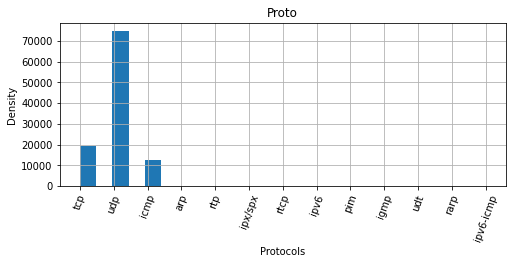

In [ ]:
if "Proto" in ctu_13_d_11.columns:
    ctu_13_d_11["Proto"].hist(figsize=(8,3), bins=25);
    plt.title("Proto")
    plt.xlabel("Protocols")
    plt.ylabel("Density")
    plt.xticks(rotation=70)
    plt.savefig("Proto_d11.png", dpi=300)

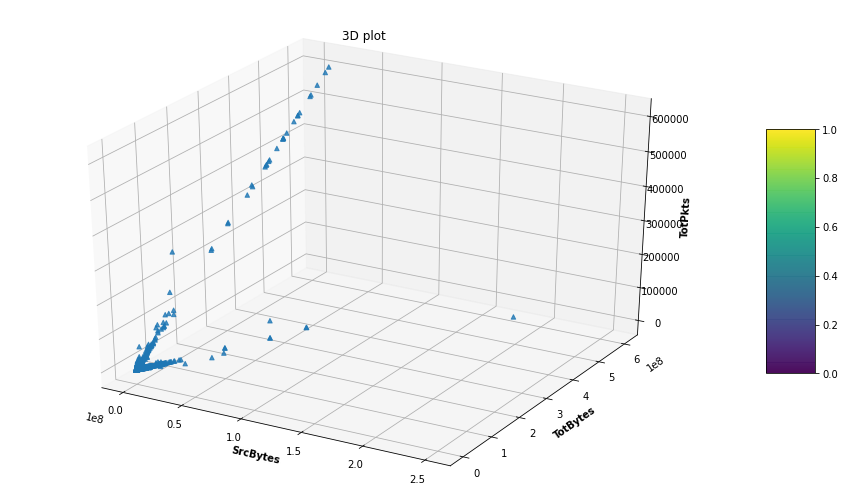

In [ ]:
#plt.scatter(ctu_13_d_6["Proto"], ctu_13_d_6["Label"], color="green")
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)
my_cmap = plt.get_cmap('hsv')
 
# Creating plot
plott=ax.scatter3D(ctu_13_d_6["SrcBytes"], ctu_13_d_6["TotBytes"], ctu_13_d_6["TotPkts"], alpha=0.8, cmap=my_cmap, marker="^")
plt.title("3D plot")
ax.set_xlabel('SrcBytes', fontweight ='bold')
ax.set_ylabel('TotBytes', fontweight ='bold')
ax.set_zlabel('TotPkts', fontweight ='bold')
fig.colorbar(plott, ax = ax, shrink = 0.5, aspect = 5)

plt.show()

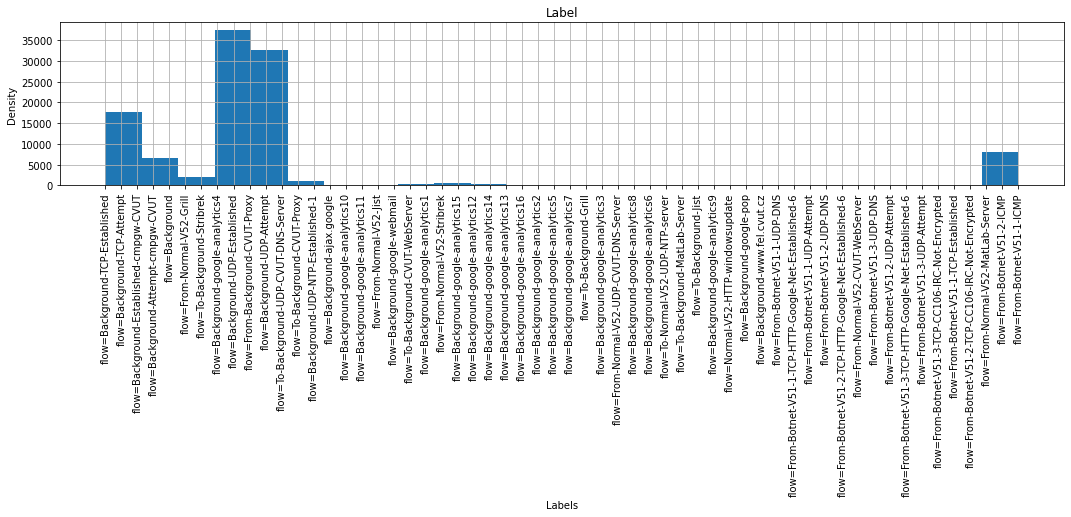

In [ ]:
if "Label" in ctu_13_d_11.columns:
    ctu_13_d_11["Label"].hist(figsize=(18,3), bins=25, orientation='vertical', alpha=1)
    plt.title("Label")
    plt.xlabel("Labels")
    plt.ylabel("Density")
    plt.xticks(rotation=90)
    plt.savefig("Labels_d11.png", dpi=300)

Distribution of Features Total bytes and Source Bytes

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


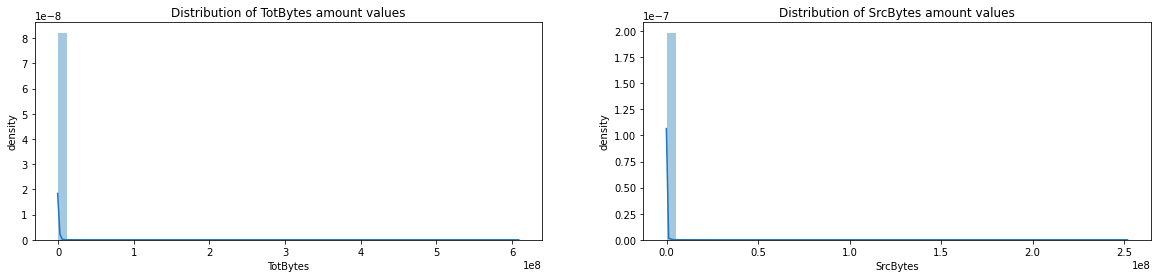

In [ ]:
# init the plots
fig, ax = plt.subplots(1,2)
fig.set_figwidth(20)

# plot distribution of the Total Bytes 
g = sns.distplot(ctu_13_d_6['TotBytes'].tolist(), ax=ax[0])
g.set_title('Distribution of TotBytes amount values')

# set axis-labels 
ax[0].set_xlabel('TotBytes')
ax[0].set_ylabel('density')

# plot distribution of the Source Bytes
g = sns.distplot(ctu_13_d_6['SrcBytes'].tolist(), ax=ax[1])
g.set_title('Distribution of SrcBytes amount values')

# set axis-labels
ax[1].set_xlabel('SrcBytes')
ax[1].set_ylabel('density');

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0, 0, 'flow=Background-TCP-Attempt'),
 Text(0, 0, 'flow=Background-Established-cmpgw-CVUT'),
 Text(0, 0, 'flow=Background-TCP-Established'),
 Text(0, 0, 'flow=Background'),
 Text(0, 0, 'flow=Background-UDP-Established'),
 Text(0, 0, 'flow=From-Background-CVUT-Proxy'),
 Text(0, 0, 'flow=Background-google-analytics2'),
 Text(0, 0, 'flow=From-Normal-V47-Jist'),
 Text(0, 0, 'flow=From-Normal-V47-UDP-CVUT-DNS-Server'),
 Text(0, 0, 'flow=To-Background-UDP-CVUT-DNS-Server'),
 Text(0, 0, 'flow=Background-UDP-NTP-Established-1'),
 Text(0, 0, 'flow=Background-google-webmail'),
 Text(0, 0, 'flow=To-Background-Grill'),
 Text(0, 0, 'flow=Background-Attempt-cmpgw-CVUT'),
 Text(0, 0, 'flow=Background-UDP-Attempt'),
 Text(0, 0, 'flow=To-Background-CVUT-Proxy'),
 Text(0, 0, 'flow=Background-google-analytics5'),
 Text(0, 0, 'flow=Background-google-analytics6'),
 Text(0, 0, 'flow=Background-google-analytics8'),
 Text(0, 0, 'flow=To-Background-Jist'),
 Text(0, 0, 'flow=Background-google-analytics9')

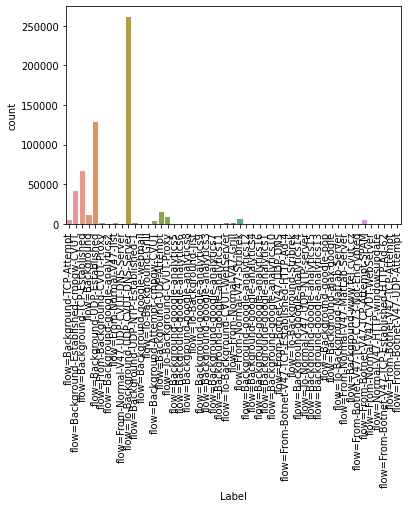

In [ ]:
ax=sns.countplot(ctu_13_d_6['Label'])
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

list of features of the dataset that are categorical

In [ ]:
ctu_13_d_6["Label"].value_counts()
len(ctu_13_d_6["Label"])

558919

Excluded features

In [ ]:
excluded_features=["StartTime", "SrcAddr", "Dir", "DstAddr"]
new_ctu_13_d_6 = ctu_13_d_6.drop(columns=excluded_features, errors='ignore')
new_ctu_13_d_10 = ctu_13_d_10.drop(columns=excluded_features, errors='ignore')
new_ctu_13_d_11 = ctu_13_d_11.drop(columns=excluded_features, errors='ignore')
new_ctu_13_d_11

,Dur,Proto,Sport,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2.983247,tcp,63577,13363,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established
1,2.906029,tcp,63580,443,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established
2,3.030517,tcp,63582,80,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established
3,6.016227,tcp,63577,13363,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established
4,6.124715,tcp,63580,443,SR_SA,0.0,0.0,3,184,122,flow=Background-TCP-Established
...,...,...,...,...,...,...,...,...,...,...,...
107246,0.000313,udp,57375,53,CON,0.0,0.0,2,207,66,flow=To-Background-UDP-CVUT-DNS-Server
107247,0.000000,udp,63550,50613,INT,0.0,NaN,1,145,145,flow=Background-Attempt-cmpgw-CVUT
107248,0.001958,udp,59481,13363,CON,0.0,0.0,2,522,462,flow=Background-UDP-Established
107249,0.000258,udp,57012,53,CON,0.0,0.0,2,208,79,flow=To-Background-UDP-CVUT-DNS-Server


In [ ]:
categorical_names=["Proto", "State"]

Text(0.5, 1.0, 'Day 11')

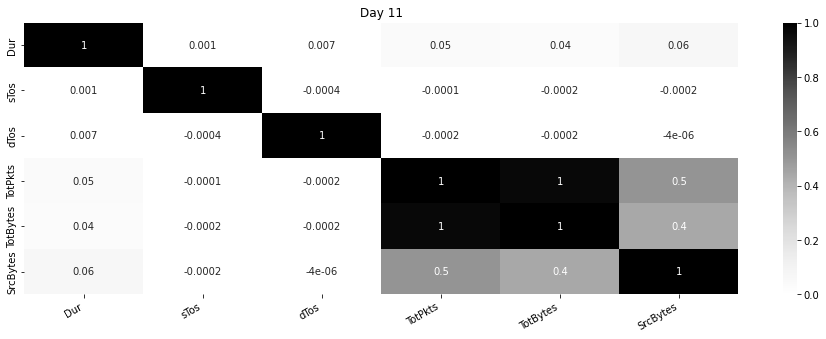

In [ ]:
corr_matrix = new_ctu_13_d_11.corr()
plt.rcParams['figure.figsize'] = (16, 5)
g = sns.heatmap(corr_matrix, annot=True, fmt='.1g', cmap='Greys')
g.set_xticklabels(g.get_xticklabels(), verticalalignment='top', horizontalalignment='right', rotation=30);
plt.savefig('corr_heatmap_d11.png', dpi=300, bbox_inches='tight')
plt.title("Day 11")

Application of one_hot encoding on these features

In [ ]:
ctu_13_d_6_transformed = pd.get_dummies(ctu_13_d_6[categorical_names])

Displaying the distribution of Labels

In [ ]:

ctu_13_d_6_transformed

,Proto_arp,Proto_esp,Proto_icmp,Proto_igmp,Proto_ipv6,Proto_ipv6-icmp,Proto_ipx/spx,Proto_pim,Proto_rtcp,Proto_rtp,...,State__FSA,State__FSPA,State__FSRPA,State__PA,State__RA,State__RPA,State__SA,State__SPA,State__SRA,State__SRPA
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
558915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
558916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
558917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Merging the whole dataset

In [ ]:
# merge categorical and numeric subsets
ctu_13_d_6_transformed = pd.concat([ctu_13_d_6_transformed, ctu_13_d_6[['TotBytes', 'SrcBytes', 'Dport', 'sTos', 'dTos']]], axis = 1)
ctu_13_d_6_transformed

,Proto_arp,Proto_esp,Proto_icmp,Proto_igmp,Proto_ipv6,Proto_ipv6-icmp,Proto_ipx/spx,Proto_pim,Proto_rtcp,Proto_rtp,...,State__RPA,State__SA,State__SPA,State__SRA,State__SRPA,TotBytes,SrcBytes,Dport,sTos,dTos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,244,124,80,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,244,124,80,0.0,0.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,244,124,80,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2636,638,80,0.0,0.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,244,124,80,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558914,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,230,90,53,0.0,0.0
558915,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,307,86,53,0.0,0.0
558916,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,254,77,53,0.0,0.0
558917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,6824,1142,443,0.0,0.0


# Simple Autoencoder

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

X_DDOS, Y_DDOS =new_data_cic_ids2017_day5_DDOS.drop('Label', axis=1, inplace=False), new_data_cic_ids2017_day5_DDOS.iloc[:, -1]
X_train_DDOS, X_test_DDOS, y_train_DDOS, y_test_DDOS = train_test_split(X_DDOS, Y_DDOS, test_size=0.30, random_state=1)
X_train_DDOS.shape


X_train_DDOS_torch = torch.from_numpy(X_train_DDOS.values).float()
X_test_DDOS_torch = torch.from_numpy(X_train_DDOS.values).float()
X_DDOS, Y_DDOS =new_data_cic_ids2017_day5_DDOS.drop('Label', axis=1, inplace=False), new_data_cic_ids2017_day5_DDOS.iloc[:, -1]
X_train_DDOS, X_test_DDOS, y_train_DDOS, y_test_DDOS = train_test_split(X_DDOS, Y_DDOS, test_size=0.30, random_state=1)
X_train_DDOS.shape
X_BENIGN, Y_BENIGN =new_data_cic_ids2017_day5_BENIGN.drop('Label', axis=1, inplace=False), new_data_cic_ids2017_day5_BENIGN.iloc[:, -1]
X_train_BENIGN, X_test_BENIGN, y_train_BENIGN, y_test_BENIGN = train_test_split(X_BENIGN, Y_BENIGN, test_size=0.30, random_state=1)
X_train_BENIGN

In [ ]:
X_train_DDOS_torch = torch.from_numpy(X_train_DDOS.values).float()
X_test_DDOS_torch = torch.from_numpy(X_test_DDOS.values).float()
X_train_DDOS_torch.shape

torch.Size([89618, 78])

In [ ]:
X_train_BENIGN_torch = torch.from_numpy(X_train_BENIGN.values).float()
X_test_BENIGN_torch = torch.from_numpy(X_test_BENIGN.values).float()
X_train_BENIGN_torch.shape

torch.Size([68402, 78])

In [ ]:
X_general=new_data_cic_ids2017_day5.drop("Label", axis=1)
X_general.shape

(225745, 78)

No handles with labels found to put in legend.


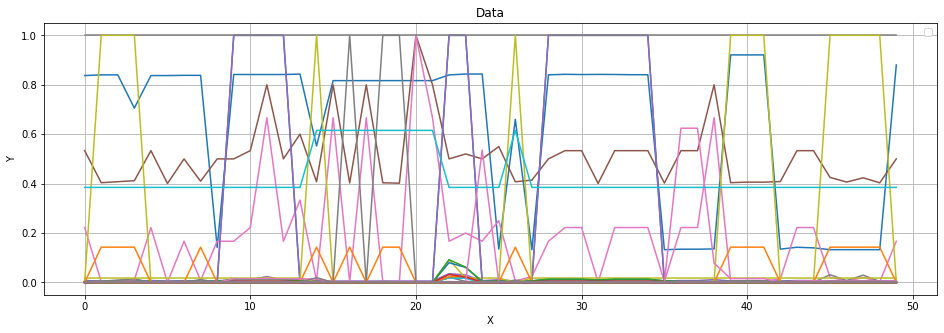

In [ ]:
plt.grid()
#fig, ax = plt.subplots()
plt.plot(np.arange(X_general[:50].shape[0]), X_general[:50])
#ax.set(facecolor = "white")
plt.title("Data")
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.savefig("data_fluctuation50")
plt.show()

In [ ]:
lr=0.1
epochs=20
batch_size=100
x_dim=X_train_BENIGN_torch.shape[1] # 78
hidden_dim=[int(x_dim/2), 35] # [39, 35]
latent_dim=number_of_principal_components_cic_ids2017
latent_dim

15

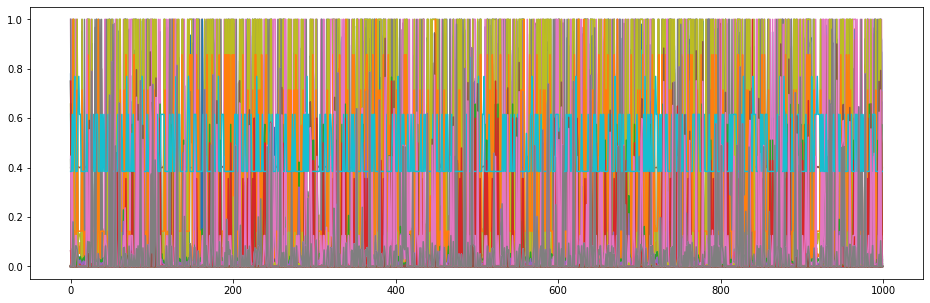

In [ ]:
plt.plot(X_train_BENIGN.values[:1000])

Building the Model

In [ ]:
class Autoencoder(Model):
  def __init__(self):
    self.latent_dimension=number_of_principal_components_cic_ids2017
    self.input_dimension=X_train_BENIGN.shape[1]
    super().__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(self.input_dimension, activation="relu"),
      layers.Dense(39, activation="relu"),
      layers.Dense(self.latent_dimension, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(self.latent_dimension, activation="relu"),
      layers.Dense(39, activation="relu"),
      layers.Dense(self.input_dimension, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

AE = Autoencoder()

In [ ]:
np.random.seed(50)

Error Criteria

In [ ]:
AE.compile(optimizer='adam', loss='mae')

Making use of early stopping

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)

In [ ]:
X_test_BENIGN.shape

(29316, 78)

Training using normal data

In [ ]:
history = AE.fit(X_train_BENIGN, X_train_BENIGN, 
          epochs=100, 
          batch_size=512,
          validation_data=(X_test_BENIGN, X_test_BENIGN),
          shuffle=True, callbacks=[earlystopping])

Epoch 1/100
134/134 [==============================] - 2s 8ms/step - loss: 0.1759 - val_loss: 0.0530
Epoch 2/100
134/134 [==============================] - 1s 6ms/step - loss: 0.0513 - val_loss: 0.0463
Epoch 3/100
134/134 [==============================] - 1s 6ms/step - loss: 0.0424 - val_loss: 0.0411
Epoch 4/100
134/134 [==============================] - 1s 6ms/step - loss: 0.0408 - val_loss: 0.0404
Epoch 5/100
134/134 [==============================] - 1s 6ms/step - loss: 0.0404 - val_loss: 0.0402
Epoch 6/100
134/134 [==============================] - 1s 6ms/step - loss: 0.0399 - val_loss: 0.0397
Epoch 7/100
134/134 [==============================] - 1s 6ms/step - loss: 0.0396 - val_loss: 0.0395
Epoch 8/100
134/134 [==============================] - 1s 6ms/step - loss: 0.0392 - val_loss: 0.0391
Epoch 9/100
134/134 [==============================] - 1s 6ms/step - loss: 0.0391 - val_loss: 0.0389
Epoch 10/100
134/134 [==============================] - 1s 6ms/step - loss: 0.0388 - val_lo

In [ ]:
acc = history.history.keys()

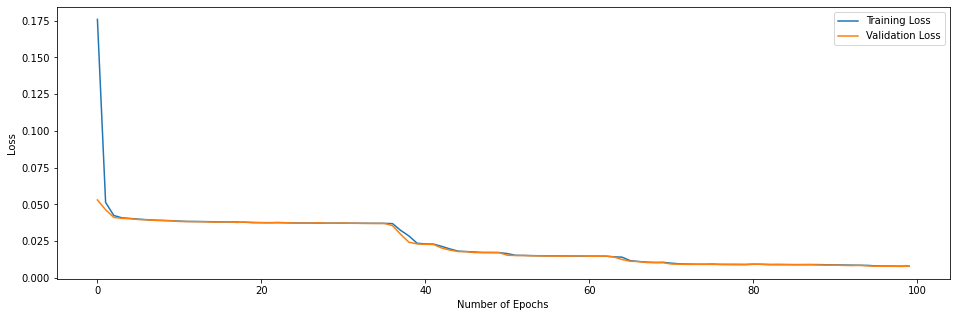

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.savefig("Loss_SAE.png")
plt.legend()

We will classify data as an attack if the reconstruction error is greater than one standard deviation from the normal training examples. We first plot a BENIGN from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

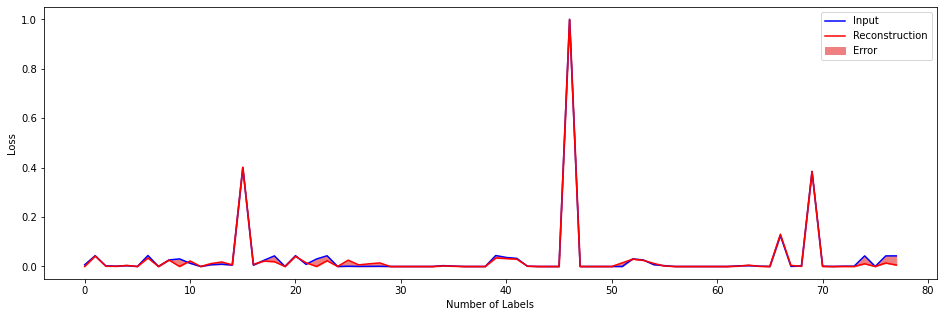

In [ ]:
encoded_data = AE.encoder(tf.constant(X_test_BENIGN)).numpy()
decoded_data = AE.decoder(encoded_data).numpy()

plt.plot(tf.constant(X_test_BENIGN)[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(tf.constant(X_test_BENIGN).shape[1]), decoded_data[0], tf.constant(X_test_BENIGN)[0], color='lightcoral')
plt.xlabel("Number of Labels")
plt.ylabel("Loss")
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

The same plot with DDOS test example

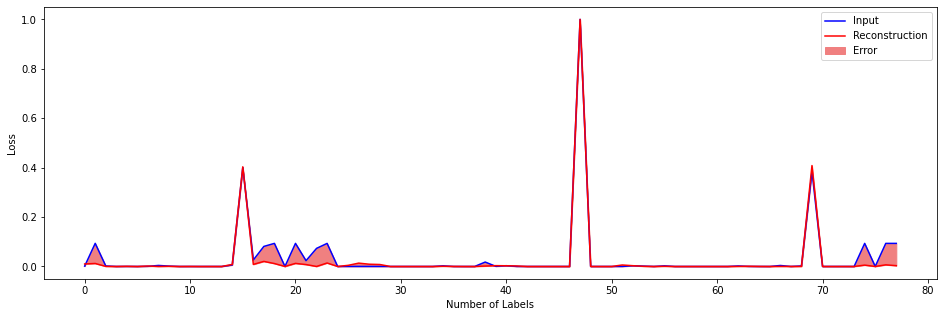

In [ ]:
encoded_data = AE.encoder(tf.constant(X_test_DDOS)).numpy()
decoded_data = AE.decoder(encoded_data).numpy()

plt.plot(tf.constant(X_test_DDOS)[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(tf.constant(X_test_DDOS).shape[1]), decoded_data[0], tf.constant(X_test_DDOS)[0], color='lightcoral')
plt.xlabel("Number of Labels")
plt.ylabel("Loss")
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

**Detecting Anomalies** <br>
We detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold or not. We do it by calculating the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

Plot of the reconstruction error on BENIGN data over the training set

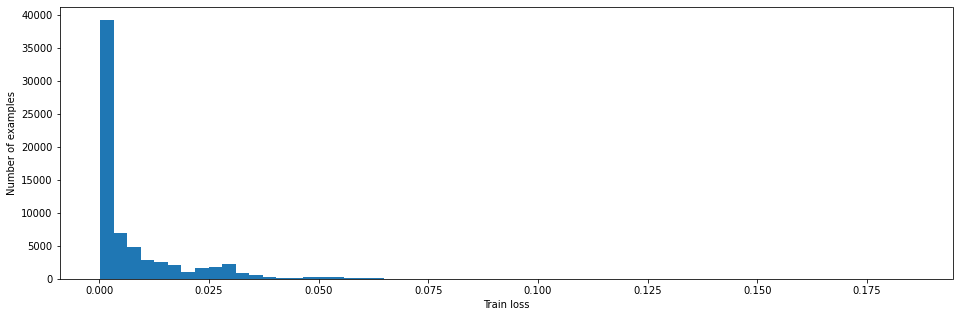

In [ ]:
reconstructions = AE.predict(X_train_BENIGN) #
train_loss = tf.keras.losses.mae(reconstructions, X_train_BENIGN)
plt.hist(train_loss[None,:], bins=60)
plt.xlabel("Train loss")
plt.ylabel("Number of examples")
plt.show()

Plot of the reconstruction error on DDOS data over the training set

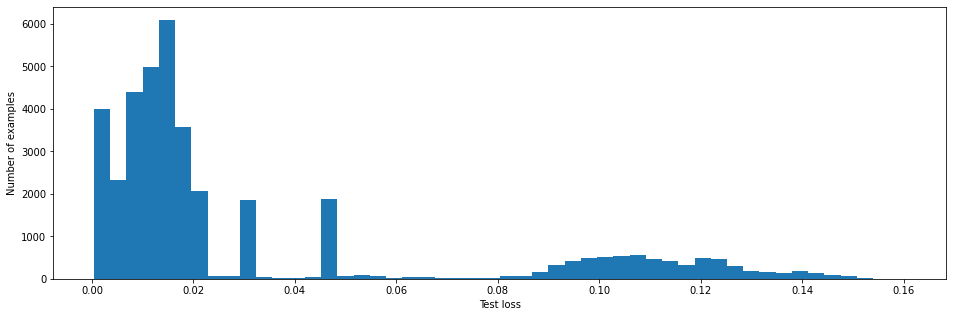

In [ ]:
reconstructions = AE.predict(X_test_DDOS)
test_loss = tf.keras.losses.mae(reconstructions, X_test_DDOS)
plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("Number of examples")
plt.show()

Classification of data as a DDOS attack if the reconstruction error is greater than the threshold.

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
accur=np.ones(len(history.history["loss"]))-history.history["loss"]

Choice of a threshold

In [ ]:
threshold = np.max(history.history["loss"])
print("Threshold: ", threshold)

Threshold:  0.1758609563112259


Prediction of DDOS attacks

In [ ]:
preds = predict(AE, tf.constant(X_test_DDOS), 0.075)
print_stats(preds, y_test_DDOS)

Accuracy = 0.8271759223098752
Precision = 1.0
Recall = 0.8271759223098752


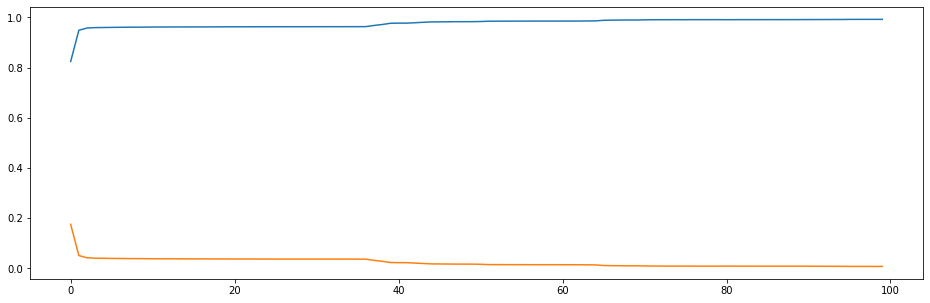

In [ ]:
accuracy=np.ones(len(history.history["loss"]))-history.history["loss"]
plt.plot(accuracy, label="Accuracy")
plt.plot(history.history["loss"], label="Loss")
plt.show()